In [13]:
#To hide warnings export PYTHONWARNINGS="ignore"
#Imports{

import os
from os.path import dirname
from os.path import join
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Cha


import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import cPickle as pickle
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

from scipy.misc import imread
from scipy.misc import imresize
from scipy.io import loadmat
from scipy.interpolate import spline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cluster import MiniBatchKMeans

import keras
from keras import backend as K
from keras.layers import Lambda
K.set_image_dim_ordering('th')
#}

Model architecture
<img src="../../data/misc/vgg16.png">

In [2]:
#Code snippet needed to read activation values from each layer of the pre-trained artificial neural networks
def get_activations(model, layer, X_batch):
    #keras.backend.function(inputs, outputs, updates=None)
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output,])
    #The learning phase flag is a bool tensor (0 = test, 1 = train)
    activations = get_activations([X_batch,0])
    return activations

In [3]:
#Function to pre-process the input image to ensure uniform size and color
def preprocess_image_batch(image_paths, img_size=None, crop_size=None, color_mode='rgb', out=None):
    """
    Consistent preprocessing of images batches
    :param image_paths: iterable: images to process
    :param crop_size: tuple: crop images if specified
    :param img_size: tuple: resize images if specified
    :param color_mode: Use rgb or change to bgr mode based on type of model you want to use
    :param out: append output to this iterable if specified
    """
    img_list = []

    for im_path in image_paths:
        img = imread(im_path, mode='RGB')
        #print im_path
        #print img.shape
        if img_size:
            img = imresize(img, img_size)

        img = img.astype('float32')
        # We normalize the colors (in RGB space) with the empirical means on the training set
        img[:, :, 0] -= 123.68
        img[:, :, 1] -= 116.779
        img[:, :, 2] -= 103.939
        # We permute the colors to get them in the BGR order
        if color_mode == 'bgr':
            img[:, :, [0, 1, 2]] = img[:, :, [2, 1, 0]]
        img = img.transpose((2, 0, 1))

        if crop_size:
            img = img[:, (img_size[0] - crop_size[0]) // 2:(img_size[0] + crop_size[0]) // 2
            , (img_size[1] - crop_size[1]) // 2:(img_size[1] + crop_size[1]) // 2]

        img_list.append(img)

    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        print im_path
        raise ValueError('when img_size and crop_size are None, images'
                ' in image_paths must have the same shapes.')

    if out is not None and hasattr(out, 'append'):
        out.append(img_batch)
    else:
        return img_batch

In [4]:
#Function to predict the top 5 accuracy
def top5accuracy(true, predicted):
    assert len(true) == len(predicted)
    result = []
    flag  = 0
    for i in range(len(true)):
        flag  = 0
        temp = true[i]
        for j in predicted[i]:
            if j == temp:
                flag = 1
                break
        if flag == 1:
            result.append(1)
        else:
            result.append(0)
    counter = 0.
    for i in result:
        if i == 1:
            counter += 1.
    error = 1.0 - counter/float(len(result))
    #print len(np.where(np.asarray(result) == 1)[0])
    return len(np.where(np.asarray(result) == 1)[0]), error

In [5]:
#Load the details of all the 1000 classes and the function to conver the synset id to words{
meta_clsloc_file = '../../data/meta_clsloc.mat'
synsets = loadmat(meta_clsloc_file)['synsets'][0]
synsets_imagenet_sorted = sorted([(int(s[0]), str(s[1][0])) for s in synsets[:1000]],key=lambda v: v[1])
corr = {}
for j in range(1000):
    corr[synsets_imagenet_sorted[j][0]] = j

corr_inv = {}
for j in range(1, 1001):
    corr_inv[corr[j]] = j

def id_to_words(id_):
    return synsets[corr_inv[id_] - 1][2][0]

def pprint_output(out, n_max_synsets=10):
    wids = []
    best_ids = out.argsort()[::-1][:10]
    for u in best_ids:
        wids.append(str(synsets[corr_inv[u] - 1][1][0]))
    #print('%.2f' % round(100 * out[u], 2) + ' : ' + id_to_words(u)+' '+ str(synsets[corr_inv[u] - 1][1][0]))
    return wids

In [6]:
#Code snippet to load the ground truth labels to measure the performance{
truth = {}
with open('../../data/ILSVRC2014_clsloc_validation_ground_truth.txt') as f:
    line_num = 1
    for line in f.readlines():
        ind_ = int(line)
        temp  = None
        for i in synsets_imagenet_sorted:
            if i[0] == ind_:
                temp = i
        #print ind_,temp
        if temp != None:
            truth[line_num] = temp
        else:
            print '##########', ind_
            pass
        line_num += 1
#}

In [16]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
from keras import layers
from keras import models
import keras.utils as keras_utils
    
from  keras.applications import imagenet_utils
from  keras.applications.imagenet_utils import decode_predictions
from  keras.applications.imagenet_utils import _obtain_input_shape

preprocess_input = imagenet_utils.preprocess_input

WEIGHTS_PATH = ('https://github.com/fchollet/deep-learning-models/'
                'releases/download/v0.1/'
                'vgg16_weights_tf_dim_ordering_tf_kernels.h5')
WEIGHTS_PATH_NO_TOP = ('https://github.com/fchollet/deep-learning-models/'
                       'releases/download/v0.1/'
                       'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')


def VGG16(include_top=True,
          weights='imagenet',
          input_tensor=None,
          input_shape=None,
          pooling=None,
          classes=1000,
          lambda_mask = None,
          **kwargs):

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(img_input)
    
    if lambda_mask is not None:
        block_1_conv_1_mask  = np.reshape(lambda_mask[0:3211264], (64, 224, 224))
    else:
        block_1_conv_1_mask = np.zeros(shape=((64, 224, 224)))
    
    block_1_conv_1_mask  = K.variable(block_1_conv_1_mask)
    block_1_conv_1_lambda = Lambda(lambda x: x * block_1_conv_1_mask)(x)
    
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(block_1_conv_1_lambda)
    
    if lambda_mask is not None:
        block_1_conv_2_mask  = np.reshape(lambda_mask[3211264:6422528], (64, 224, 224))
    else:
        block_1_conv_2_mask = np.zeros(shape=((64, 224, 224)))
    
    block_1_conv_2_mask  = K.variable(block_1_conv_2_mask)
    block_1_conv_2_lambda = Lambda(lambda x: x * block_1_conv_2_mask)(x)
    
    
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(block_1_conv_2_lambda)

    # Block 2
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    
    if lambda_mask is not None:
        block_2_conv_1_mask  = np.reshape(lambda_mask[6422528:8028160], (128, 112, 112))
    else:
        block_2_conv_1_mask = np.zeros(shape=((128, 112, 112)))
    
    block_2_conv_1_mask  = K.variable(block_2_conv_1_mask)
    block_2_conv_1_lambda = Lambda(lambda x: x * block_2_conv_1_mask)(x)
    
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(block_2_conv_1_lambda)
    
    
    if lambda_mask is not None:
        block_2_conv_2_mask  = np.reshape(lambda_mask[8028160:9633792], (128, 112, 112))
    else:
        block_2_conv_2_mask = np.zeros(shape=((128, 112, 112)))
    
    block_2_conv_2_mask  = K.variable(block_2_conv_2_mask)
    block_2_conv_2_lambda = Lambda(lambda x: x * block_2_conv_2_mask)(x)
    
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(block_2_conv_2_lambda )

    # Block 3
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv1')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv2')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = layers.Flatten(name='flatten')(x)
        x = layers.Dense(4096, activation='relu', name='fc1')(x)
        x = layers.Dense(4096, activation='relu', name='fc2')(x)
        x = layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = models.Model(inputs, x, name='vgg16')

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            weights_path = keras_utils.get_file(
                'vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                file_hash='64373286793e3c8b2b4e3219cbf3544b')
        else:
            weights_path = keras_utils.get_file(
                'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                file_hash='6d6bbae143d832006294945121d1f1fc')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            keras_utils.convert_all_kernels_in_model(model)
    elif weights is not None:
        model.load_weights(weights)

    return model

In [15]:
model_name = 'VGG16'
model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3, 224, 224)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 224, 224)      1792      
_________________________________________________________________
lambda_1 (Lambda)            (None, 64, 224, 224)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 224, 224)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 112, 112)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 112, 112)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 112, 112)     147584    
__________

In [46]:
K.image_data_format()

'channels_first'

In [ ]:
%%time
#Test Cell 1

data_path = '../../data/pkl/'
classes = ['animate','inanimate']
fold = 1

with open(data_path+classes[0]+'_train_'+model_name+'.pkl') as f:
        X_fold = pickle.load(f)
with open(data_path+classes[1]+'_train_'+model_name+'.pkl') as f:
        y_fold = pickle.load(f)
    
X = np.column_stack((X_fold,y_fold))
X = np.float32(X)


kmeans = MiniBatchKMeans(n_clusters=67783, #200x reduction in points
                         max_iter=10).fit(X)

pred_kmeans = kmeans.predict(X)

X_new = kmeans.cluster_centers_

with open('../../data/pkl/kmeans_first_train_'+model_name+'.pkl', 'wb') as handle:
    pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
%%time
#Version 1 - Reading pkl files from step 0 and clustering it{
data_path = '../../data/pkl/'
classes = ['animate','inanimate']


result= {}

k = 4 #Total Number of folds
fold = 1

for i in range(k):
    
    print('Perfoming Fold: ', fold)
    clf_result = {}
    
    if os.path.exists('../../data/pkl/kmeans_first_'+str(fold)+'_'+model_name+'.pkl'):
        with open('../../data/pkl/kmeans_first_'+str(fold)+'_'+model_name+'.pkl',"rb") as f:
            X_new,pred_kmeans,kmeans = pickle.load(f)
    else:   
        with open(data_path+classes[0]+'_fold_'+str(fold)+'_train_'+model_name+'.pkl') as f:
            X_fold = pickle.load(f)
        with open(data_path+classes[1]+'_fold_'+str(fold)+'_train_'+model_name+'.pkl') as f:
            y_fold = pickle.load(f)

        X = np.column_stack((X_fold,y_fold))
        kmeans = MiniBatchKMeans(n_clusters=67783,
                                 max_iter=10).fit(X)
        #print kmeans.cluster_centers_
        pred_kmeans = kmeans.predict(X)
        X_new = kmeans.cluster_centers_

        with open('../../data/pkl/kmeans_first_'+str(fold)+'_'+model_name+'.pkl', 'wb') as handle:
            pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

    #DO CLUSTERING AND GET CLUSTERS
    
    from sklearn.cluster import KMeans
    from sklearn.cluster import SpectralClustering
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.cluster import Birch
    from sklearn.mixture import GaussianMixture
    
    method ='GMM'
    print(method)
    for j in range(1,51,1):
 
        clf_result[j] = {}

        clf = KMeans(n_clusters=j)    
        #clf =  AgglomerativeClustering(n_clusters=j, linkage='ward')
        #clf = Birch(branching_factor=50, n_clusters=j, threshold=0.5,compute_labels=True)
        clf = GaussianMixture(n_components=j, covariance_type='full')
        y_pred = clf.fit_predict(X_new)
        #print clf.cluster_centers_

        for label in set(y_pred):
            print('Cluster: ',j,'Label: ', label)
            
            #Lesioning and measuring performance
            pred = y_pred.copy()
            loc = np.where(pred==label)
            loc_temp = kmeans.predict(X_new[loc[0]])
            loc_new =[]
            for entry in set(loc_temp):
                temp = np.where(pred_kmeans==entry)[0]
                loc_new.extend(temp)

            lambda_mask = np.ones(shape=((13556712,)))
            lambda_mask[loc_new] = 0.

            #plt.scatter(X[:,0],X[:,1], c=y_pred) 
            #Change Model
            model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000,lambda_mask=lambda_mask)

            flag = 0
            dprime = 0.
            for p in classes:
                im_valid_test = []
                image_list_valid = '../../data/pkl/'+p+'_image_list_valid_fold_'+str(fold)+'.txt'
                with open(image_list_valid,'rb') as f:
                    for line in f.readlines():
                        im_valid_test.append(line.strip('\n'))
                im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
                out = model.predict(im_temp,batch_size=64)

                true_valid_wids = []
                for i in im_valid_test:
                        temp1 = i.split('/')[4]
                        temp = temp1.split('.')[0].split('_')[2]
                        true_valid_wids.append(truth[int(temp)][1])

                predicted_valid_wids = []
                for i in range(len(im_valid_test)):
                    #print im_list[i], pprint_output(out[i]), true_wids[i]
                    predicted_valid_wids.append(pprint_output(out[i]))

                count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

                print(str(p)+' '+str(fold)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error))
                
                if flag == 0:
                    dprime = error
                    flag = 1
                else:
                    dprime -= error
                    
            clf_result[j][label] = dprime
    
    with open('../../data/pkl/'+str(method)+'_50_scree_fold_'+str(fold)+'_'+model_name+'.pkl', 'wb') as handle:
        pickle.dump(clf_result, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    result[fold] = clf_result
    fold += 1
#}

Perfoming Fold:  1
GMM
Cluster:  1 Label:  0


In [26]:
result[1]

{1: {0: -0.02564102564102566},
 2: {0: -0.02564102564102566, 1: -0.02564102564102566},
 3: {0: -0.02564102564102566,
  1: -0.02564102564102566,
  2: -0.02564102564102566},
 4: {0: -0.02564102564102566,
  1: -0.02564102564102566,
  2: -0.02564102564102566,
  3: -0.02564102564102566},
 5: {0: -0.02564102564102566,
  1: -0.02564102564102566,
  2: -0.02564102564102566,
  3: -0.02564102564102566,
  4: -0.02564102564102566},
 6: {0: -0.02564102564102566,
  1: -0.02564102564102566,
  2: -0.02564102564102566,
  3: -0.02564102564102566,
  4: -0.02564102564102566,
  5: -0.02564102564102566},
 7: {0: -0.02564102564102566,
  1: -0.02564102564102566,
  2: -0.02564102564102566,
  3: -0.02564102564102566,
  4: -0.02564102564102566,
  5: -0.02564102564102566,
  6: -0.02564102564102566},
 8: {0: -0.02564102564102566,
  1: -0.02564102564102566,
  2: -0.02564102564102566,
  3: -0.02564102564102566,
  4: -0.02564102564102566,
  5: -0.02564102564102566,
  6: -0.02564102564102566,
  7: -0.02564102564102566}

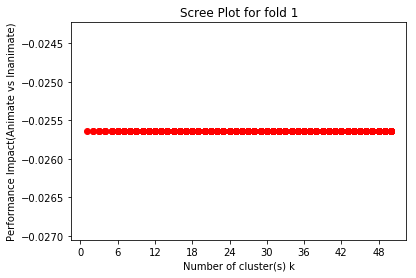

In [18]:
f = 1
clf_result = result[f]


fig = plt.figure(1)
X = range(1,51,1)
#X = range(2,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance Impact(Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
#plt.savefig('../../results/scree/'+str(method)+'_results_fold_'+str(f)+'.png', format='png', dpi=200)

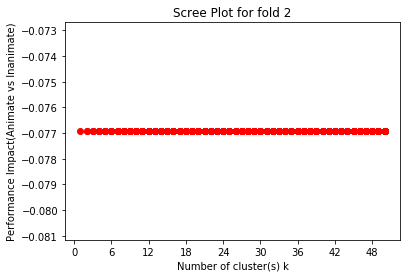

In [19]:
f = 2
clf_result = result[f]


fig = plt.figure(1)
X = range(1,51,1)
#X = range(2,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance Impact(Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
#plt.savefig('../../results/scree/'+str(method)+'_results_fold_'+str(f)+'.png', format='png', dpi=200)

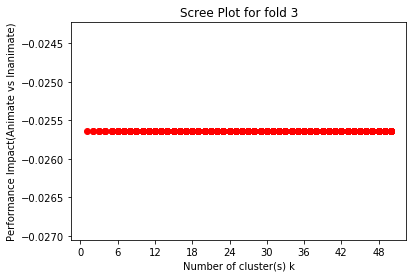

In [20]:
f = 3
clf_result = result[f]


fig = plt.figure(1)
X = range(1,51,1)
#X = range(2,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance Impact(Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
#plt.savefig('../../results/scree/'+str(method)+'_results_fold_'+str(f)+'.png', format='png', dpi=200)

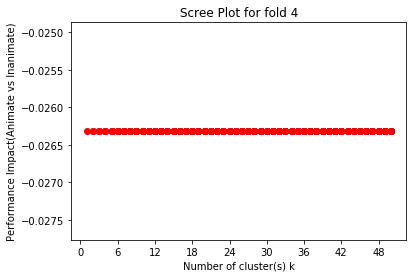

In [21]:
f = 4
clf_result = result[f]


fig = plt.figure(1)
X = range(1,51,1)
#X = range(2,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance Impact(Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
#plt.savefig('../../results/scree/'+str(method)+'_results_fold_'+str(f)+'.png', format='png', dpi=200)

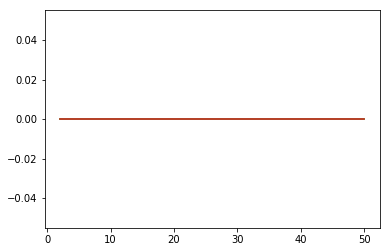

In [22]:
#Find MaxAd', MaxId' and its average
plt.figure()
noc = 4
for i in range(1,noc+1,1):
    X = []
    Y = []
    for j in range(2,51,1):
        X.append(j)
        temp = []
        for key, value in result[i][j].iteritems():
            temp.append(value)
        maxa = max(temp)
        maxi = min(temp)
        avg = float(maxa - maxi)
        Y.append(avg)
    #print X,Y
    plt.plot(X,Y)

-0.0320512820513 1


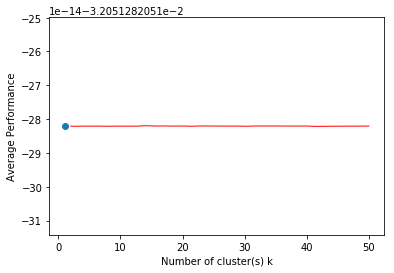

In [25]:
#Smooth average graph

noc = 4
flag = 0
X = range(2,51,1)
an_fold =[]
ian_fold = []
Y = []
for i in range(1,noc+1,1):
    if i == 2:
        flag = 1
    for j in range(2,51,1):
        temp = []
        for key, value in result[i][j].iteritems():
            temp.append(value)
        maxa = max(temp)
        maxi = min(temp)
        if flag == 0:
            an_fold.append(maxa)
            ian_fold.append(maxi)
        else:
            an_fold[j-2] += maxa
            ian_fold[j-2] = maxi

for j in range(2,51,1):
    maxa = (an_fold[j-2]) / 4.
    maxi = (ian_fold[j-2]) /4.
    diff = maxa - maxi
    Y.append(diff)
    
x_sm = np.array(X)
y_sm = np.array(Y)

x_smooth = np.linspace(x_sm.min(), x_sm.max(), 200)
y_smooth = spline(X, Y, x_smooth)

plt.plot(x_smooth, y_smooth, 'r', linewidth=1)
plt.plot(Y.index(max(Y))+1,max(Y),'o')
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Average Performance")
plt.savefig('../../results/scree/'+str(method)+'_results_fold_avg.png', format='png', dpi=200)
print max(Y), Y.index(max(Y)) + 1